In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as f
import numpy as np
import pandas as np
import matplotlib
import matplotlib.pyplot as mlp
import gymnasium as gym
import random
import math
from collections import namedtuple,deque
from itertools import count

In [49]:
env=gym.make('CartPole-v1')
is_ipython='inline'in matplotlib.get_backend()
if is_ipython:
    from IPython import display
mlp.ion()

device=torch.device('cuda'if torch.cuda.is_available()else'cpu')
print(device)

cuda


In [50]:
#재현 메모리(Replay Memory)
Transition = namedtuple('Transition',('state', 'action', 'next_state', 'reward'))

class RPM(object):
    def __init__(self,capacity):
        self.memory=deque([],maxlen=capacity)
    
    def push(self,*args):
        self.memory.append(Transition(*args))

    def sample(self,batch_size):
        return random.sample(self.memory,batch_size)

    def __len__(self):
        return len(self.memory)


#DQN 알고리즘
class DQN(nn.Module):
    def __init__(self,n_obs,n_act):
        super(DQN,self).__init__()
        self.layer1=nn.Linear(n_obs,128)
        self.layer2=nn.Linear(128,128)
        self.layer3=nn.Linear(128,n_act)

    def forward(self,x):
        x=f.relu(self.layer1(x))
        print(x)
        x=f.relu(self.layer2(x))
        print(x)
        return self.layer3(x)




In [51]:
batch=128
gamma=0.99
start=0.9
end=0.05
decay=1000
tau=0.0005
lr=1e-4


n_act=env.action_space.n
state, info=env.reset()
n_obs=len(state)

polish=DQN(n_obs,n_act).to(device)
target=DQN(n_obs,n_act).to(device)
target.load_state_dict(polish.state_dict())

opt=optim.Adam(polish.parameters(),lr=lr)
memory=RPM(10000)

state_done=0

def select_act(state):
    global steps_done
    sample=random.random()
    threshold=end+(start-end) * \
        math.exp(-1. * state_done/decay)
    step_done+=1
    if sample>threshold:
        with torch.no_grad():
            return polish(state),max(1)[1].view(1,1)
    else:
        return torch.tensor([[env.act_space.sample()]],device=device,dtype=torch.long)

episode_dueation=[]

def plot_duration(show_result=False):
    mlp.figure(1)
    duration_t=torch.tensor(episode_dueation,dtype=torch.float)
    if show_result:
        mlp.title('Result')
    else:
        mlp.clf()
        mlp.title('Training...')
    mlp.xlabel('Episode')
    mlp.ylabel('Duration')
    mlp.plot(durations_t.numpy())

    if len(duration_t)>=100:
        mean=duration_t.unfold(0,100,1).mean(1).view(-1)
        mean=torch.cat((torch.zeros(99),mean))
        mlp.plot(means.numpy())

    plt.pause(0.001) 
    if is_ipython:
        if not show_result:
            display.display(mlp.gcf())
            display.clear_output(wait=True)
        else:
            display.display(mlp.gcf())
            

In [52]:
def optim_model():
    if len(memory)<batch:
        return
    transition=memory.sample(batch)
    batchss=Transition(*zip(*transition))
    non_final_mask=torch.tensor(tuple(map(lambda s:s is not None,batchss.next_state)),device=device,dtype=torch.bool)
    non_final_next_state=torch.cat([s for s in batchss.next_state if s is not None])
    state_batch=torch.cat(batchss.state)
    sction_batch=torch.cat(batchss.action)
    reward_batch = torch.cat(batchss.reward)
    state_action_value=polish(state_batch).gather(1,action_batch)
    next_state_value=torch.zeros(batch,device=device)
    with torch.no_grad():
        next_state_value[non_final_mask]=target(non_final_next_state).max(1)[0]
    expected_state_action_value=(next_state_value*gamma)+reward_batch
    criter=nn.SmoothL1Loss()
    loss-criter(state_action_value,expected_state_action_value.unsqueeze(1))
    opt.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(polish.parameters(),100)
    opt.step()
    

In [53]:
if torch.cuda.is_available():
    num_epoch=600
else:
    num_epoch=50

for i_episode in range(num_epoch):
    state,info=env.reset()
    state=torch.tensor(state,dtype=torch.float32,device=device).unsqueeze(0)
    for t in count():
        action=select_act(state)
        obser,reward,terminate,truncate,_=env.step(action,item())
        reward=torch.tensor([reward],device=device)
        done=terminate or truncate
        if terminate:
            next_state=None
        else:
            next_state=torch.tensor(obser,dtype=torch.float32,device=device).unsqueeze(0)
        memory.push(state,action,next_state,reward)
        state=next_state
        optim_model()
        target_net_state_dict=target.state_dict()
        policy_net_state_dict=polish.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key]=policy_net_state_dict[key]*tau+target_net_state_dict[key]*(1-tau)
            target.load_state_dict(target_net_state_dict)

        if done:
            episode_dueation.append(t+1)
            plot_duration()
            break

print('Complete')
plot_durations(show_result=True)
mlp.ioff()
mlp.show()

UnboundLocalError: local variable 'step_done' referenced before assignment

In [54]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = gym.make("CartPole-v1")

# matplotlib 설정
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# GPU를 사용할 경우
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [55]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """transition 저장"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [56]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # 최적화 중에 다음 행동을 결정하기 위해서 하나의 요소 또는 배치를 이용해 호촐됩니다.
    # ([[left0exp,right0exp]...]) 를 반환합니다.
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [57]:
# BATCH_SIZE는 리플레이 버퍼에서 샘플링된 트랜지션의 수입니다.
# GAMMA는 이전 섹션에서 언급한 할인 계수입니다.
# EPS_START는 엡실론의 시작 값입니다.
# EPS_END는 엡실론의 최종 값입니다.
# EPS_DECAY는 엡실론의 지수 감쇠(exponential decay) 속도 제어하며, 높을수록 감쇠 속도가 느립니다.
# TAU는 목표 네트워크의 업데이트 속도입니다.
# LR은 ``AdamW`` 옵티마이저의 학습율(learning rate)입니다.
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# gym 행동 공간에서 행동의 숫자를 얻습니다.
n_actions = env.action_space.n
# 상태 관측 횟수를 얻습니다.
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max (1)은 각 행의 가장 큰 열 값을 반환합니다.
            # 최대 결과의 두번째 열은 최대 요소의 주소값이므로,
            # 기대 보상이 더 큰 행동을 선택할 수 있습니다.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # 100개의 에피소드 평균을 가져 와서 도표 그리기
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # 도표가 업데이트되도록 잠시 멈춤
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [58]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). 이것은 batch-array의 Transitions을 Transition의 batch-arrays로
    # 전환합니다.
    batch = Transition(*zip(*transitions))

    # 최종이 아닌 상태의 마스크를 계산하고 배치 요소를 연결합니다
    # (최종 상태는 시뮬레이션이 종료 된 이후의 상태)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Q(s_t, a) 계산 - 모델이 Q(s_t)를 계산하고, 취한 행동의 열을 선택합니다.
    # 이들은 policy_net에 따라 각 배치 상태에 대해 선택된 행동입니다.
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # 모든 다음 상태를 위한 V(s_{t+1}) 계산
    # non_final_next_states의 행동들에 대한 기대값은 "이전" target_net을 기반으로 계산됩니다.
    # max(1)[0]으로 최고의 보상을 선택하십시오.
    # 이것은 마스크를 기반으로 병합되어 기대 상태 값을 갖거나 상태가 최종인 경우 0을 갖습니다.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # 기대 Q 값 계산
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Huber 손실 계산
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # 모델 최적화
    optimizer.zero_grad()
    loss.backward()
    # 변화도 클리핑 바꿔치기
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Complete


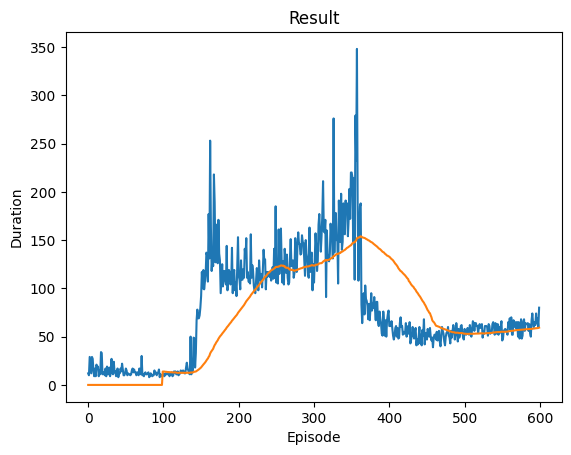

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [59]:
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    # 환경과 상태 초기화
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # 메모리에 변이 저장
        memory.push(state, action, next_state, reward)

        # 다음 상태로 이동
        state = next_state

        # (정책 네트워크에서) 최적화 한단계 수행
        optimize_model()

        # 목표 네트워크의 가중치를 소프트 업데이트
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

In [123]:
from collections import defaultdict
import matplotlib.pyplot as plt
import torch
from tensordict.nn import TensorDictModule
from tensordict.nn.distributions import NormalParamExtractor
from torch import nn
from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage
from torchrl.envs import (
    Compose,
    DoubleToFloat,
    ObservationNorm,
    StepCounter,
    TransformedEnv,
)
from torchrl.envs.libs.gym import GymEnv
from torchrl.envs.utils import check_env_specs, set_exploration_mode
from torchrl.modules import ProbabilisticActor, TanhNormal, ValueOperator
from torchrl.objectives import ClipPPOLoss
from torchrl.objectives.value import GAE
from tqdm import tqdm

In [124]:
device='cpu'if not torch.has_cuda else 'cuda:0'
print(device)
num_cells = 256  # number of cells in each layer
lr = 3e-4
max_grad_norm = 1.0


cuda:0


/tmp/ipykernel_4713/4224878182.py:1: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  device='cpu'if not torch.has_cuda else 'cuda:0'


In [125]:
#Data collection parameters


frame_skip=1
frame_per_batch=1000//frame_skip
toral_frame=50_000//frame_skip

#PPO parameters
sub_batch_size=64
num_epoch=100
clip_epsilon=(0.2)
gamma=0.99
lmbda=0.95
entropy_eps = 1e-4



#Define an environment

base_env=GymEnv('InvertedDoublePendulum-v4',device=device,frame_skip=frame_skip)

#Transforms&Normalization
env=TransformedEnv(
    base_env,
    Compose(
        ObservationNorm(in_keys=["observation"]),
        DoubleToFloat(in_keys=["observation"]),
        StepCounter()
    ),
)
env.transform[0].init_stats(num_iter=1000,reduce_dim=0,cat_dim=0)
print("normalization constant shape:", env.transform[0].loc.shape)
print("observation_spec:", env.observation_spec)
print("reward_spec:", env.reward_spec)
print("input_spec:", env.input_spec)
print("action_spec (as defined by input_spec):", env.action_spec)
check_env_specs(env)
rollout = env.rollout(3)
print("rollout of three steps:", rollout)
print("Shape of the rollout TensorDict:", rollout.batch_size)

/home/eternal/.local/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.num_envs to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.num_envs` for environment variables or `env.get_wrapper_attr('num_envs')` that will search the reminding wrappers.
  logger.warn(
/home/eternal/.local/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.reward_space to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.reward_space` for environment variables or `env.get_wrapper_attr('reward_space')` that will search the reminding wrappers.
  logger.warn(


normalization constant shape: torch.Size([11])
observation_spec: CompositeSpec(
    observation: UnboundedContinuousTensorSpec(
        shape=torch.Size([11]),
        space=None,
        device=cuda:0,
        dtype=torch.float32,
        domain=continuous),
    step_count: BoundedTensorSpec(
        shape=torch.Size([1]),
        space=ContinuousBox(
            low=Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.int64, contiguous=True),
            high=Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.int64, contiguous=True)),
        device=cuda:0,
        dtype=torch.int64,
        domain=continuous), device=cuda:0, shape=torch.Size([]))
reward_spec: UnboundedContinuousTensorSpec(
    shape=torch.Size([1]),
    space=ContinuousBox(
        low=Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.float32, contiguous=True),
        high=Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.float32, contiguous=True)),
    device=cuda:0,
    dtype=torch.float32

In [126]:
#Policy

act_net=nn.Sequential(
    nn.LazyLinear(num_cells,device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells,device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells,device=device),
    nn.Tanh(),
    nn.LazyLinear(2 * env.action_spec.shape[-1],device=device),
    NormalParamExtractor(),
)

polisy_module=TensorDictModule(
    act_net,in_keys=["observation"],out_keys=['loc','scale']
)

policy_module=ProbabilisticActor(
    module=polisy_module,
    spec=env.action_spec,
    in_keys=["loc", "scale"],
    distribution_class=TanhNormal,
    distribution_kwargs={
        "min": env.action_spec.space.minimum,
        "max": env.action_spec.space.maximum,
    },
    return_log_prob=True,
)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [127]:
#Value network
value_net=nn.Sequential(
    nn.LazyLinear(num_cells,device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells,device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells,device=device),
    nn.Tanh(),
    nn.LazyLinear(1,device=device),
)

value_module=ValueOperator(
    module=value_net,
    in_keys=['observation']
)
print("Running policy:", policy_module(env.reset()))
print("Running value:", value_module(env.reset()))

Running policy: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.float32, is_shared=True),
        done: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.bool, is_shared=True),
        loc: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.float32, is_shared=True),
        observation: Tensor(shape=torch.Size([11]), device=cuda:0, dtype=torch.float32, is_shared=True),
        sample_log_prob: Tensor(shape=torch.Size([]), device=cuda:0, dtype=torch.float32, is_shared=True),
        scale: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.float32, is_shared=True),
        step_count: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.int64, is_shared=True),
        terminated: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.bool, is_shared=True),
        truncated: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.bool, is_shared=True)},
    batch_size=torch.Size([]),
    device=cuda:0,
    is_sh

In [128]:
#Data collector
collector=SyncDataCollector(
    env,
    policy_module,
    frames_per_batch=frame_per_batch,
    total_frames=toral_frame,
    split_trajs=False,
    device=device,
)

#Replay buffer
replay_buffer=ReplayBuffer(
    storage=LazyTensorStorage(frame_per_batch),
    sampler=SamplerWithoutReplacement(),
)

#Loss function
advantage_module = GAE(
    gamma=gamma, lmbda=lmbda, value_network=value_module, average_gae=True
)
loss_module=ClipPPOLoss(
    actor=policy_module,
    critic=value_module,
    advantage_key="advantage", 
    clip_epsilon=clip_epsilon,
    entropy_bonus=bool(entropy_eps),
    entropy_coef=entropy_eps,
    value_target_key=advantage_module.value_target_key,
    critic_coef=1.0,
    gamma=0.99,
    loss_critic_type="smooth_l1",
)

opt=torch.optim.Adam(loss_module.parameters(),lr)
scheduler=torch.optim.lr_scheduler.CosineAnnealingLR(                                    
    opt,toral_frame//frame_per_batch,0.0
)

In [136]:
#Training loop

logs = defaultdict(list)
pbar = tqdm(total=toral_frame * frame_skip)
eval_str = ""

# We iterate over the collector until it reaches the total number of frames it was
# designed to collect:
for i, tensordict_data in enumerate(collector):
    # we now have a batch of data to work with. Let's learn something from it.
    for _ in range(num_epoch):
        # We'll need an "advantage" signal to make PPO work.
        # We re-compute it at each epoch as its value depends on the value
        # network which is updated in the inner loop.
        advantage_module(tensordict_data)
        data_view = tensordict_data.reshape(-1)
        replay_buffer.extend(data_view.cpu())
        for _ in range(frame_per_batch // sub_batch_size):
            subdata = replay_buffer.sample(sub_batch_size)
            loss_vals = loss_module(subdata.to(device))
            loss_value = (
                loss_vals["loss_objective"]
                + loss_vals["loss_critic"]
                + loss_vals["loss_entropy"]
            )

            # Optimization: backward, grad clipping and optimization step
            loss_value.backward()
            # this is not strictly mandatory but it's good practice to keep
            # your gradient norm bounded
            torch.nn.utils.clip_grad_norm_(loss_module.parameters(), max_grad_norm)
            opt.step()
            opt.zero_grad()

    logs["reward"].append(tensordict_data["next", "reward"].mean().item())
    pbar.update(tensordict_data.numel() * frame_skip)
    cum_reward_str = (
        f"average reward={logs['reward'][-1]: 4.4f} (init={logs['reward'][0]: 4.4f})"
    )
    logs["step_count"].append(tensordict_data["step_count"].max().item())
    stepcount_str = f"step count (max): {logs['step_count'][-1]}"
    logs["lr"].append(optim.param_groups[0]["lr"])
    lr_str = f"lr policy: {logs['lr'][-1]: 4.4f}"
    if i % 10 == 0:
        # We evaluate the policy once every 10 batches of data.
        # Evaluation is rather simple: execute the policy without exploration
        # (take the expected value of the action distribution) for a given
        # number of steps (1000, which is our ``env`` horizon).
        # The ``rollout`` method of the ``env`` can take a policy as argument:
        # it will then execute this policy at each step.
        with set_exploration_mode("mean"), torch.no_grad():
            # execute a rollout with the trained policy
            eval_rollout = env.rollout(1000, policy_module)
            logs["eval reward"].append(eval_rollout["next", "reward"].mean().item())
            logs["eval reward (sum)"].append(
                eval_rollout["next", "reward"].sum().item()
            )
            logs["eval step_count"].append(eval_rollout["step_count"].max().item())
            eval_str = (
                f"eval cumulative reward: {logs['eval reward (sum)'][-1]: 4.4f} "
                f"(init: {logs['eval reward (sum)'][0]: 4.4f}), "
                f"eval step-count: {logs['eval step_count'][-1]}"
            )
            del eval_rollout
    pbar.set_description(", ".join([eval_str, cum_reward_str, stepcount_str, lr_str]))

    # We're also using a learning rate scheduler. Like the gradient clipping,
    # this is a nice-to-have but nothing necessary for PPO to work.
    scheduler.step()





  0%|                                                 | 0/50000 [00:19<?, ?it/s]

  2%|▋                                    | 1000/50000 [00:05<04:40, 174.77it/s]

AttributeError: module 'torch.optim' has no attribute 'param_groups'


  2%|▋                                    | 1000/50000 [00:20<04:40, 174.77it/s]

In [ ]:
#Results
mlp.figure(figsize=(10, 10))
plp.subplot(2, 2, 1)
mlp.plot(logs["reward"])
mlp.title("training rewards (average)")
mlp.subplot(2, 2, 2)
mlp.plot(logs["step_count"])
mlp.title("Max step count (training)")
mlp.subplot(2, 2, 3)
mlp.plot(logs["eval reward (sum)"])
mlp.title("Return (test)")
mlp.subplot(2, 2, 4)
mlp.plot(logs["eval step_count"])
mlp.title("Max step count (test)")
mlp.show()

In [ ]:
logs = defaultdict(list)
pbar = tqdm(total=total_frames * frame_skip)
eval_str = ""

# We iterate over the collector until it reaches the total number of frames it was
# designed to collect:
for i, tensordict_data in enumerate(collector):
    # we now have a batch of data to work with. Let's learn something from it.
    for _ in range(num_epochs):
        # We'll need an "advantage" signal to make PPO work.
        # We re-compute it at each epoch as its value depends on the value
        # network which is updated in the inner loop.
        advantage_module(tensordict_data)
        data_view = tensordict_data.reshape(-1)
        replay_buffer.extend(data_view.cpu())
        for _ in range(frames_per_batch // sub_batch_size):
            subdata = replay_buffer.sample(sub_batch_size)
            loss_vals = loss_module(subdata.to(device))
            loss_value = (
                loss_vals["loss_objective"]
                + loss_vals["loss_critic"]
                + loss_vals["loss_entropy"]
            )

            # Optimization: backward, grad clipping and optimization step
            loss_value.backward()
            # this is not strictly mandatory but it's good practice to keep
            # your gradient norm bounded
            torch.nn.utils.clip_grad_norm_(loss_module.parameters(), max_grad_norm)
            optim.step()
            optim.zero_grad()

    logs["reward"].append(tensordict_data["next", "reward"].mean().item())
    pbar.update(tensordict_data.numel() * frame_skip)
    cum_reward_str = (
        f"average reward={logs['reward'][-1]: 4.4f} (init={logs['reward'][0]: 4.4f})"
    )
    logs["step_count"].append(tensordict_data["step_count"].max().item())
    stepcount_str = f"step count (max): {logs['step_count'][-1]}"
    logs["lr"].append(optim.param_groups[0]["lr"])
    lr_str = f"lr policy: {logs['lr'][-1]: 4.4f}"
    if i % 10 == 0:
        # We evaluate the policy once every 10 batches of data.
        # Evaluation is rather simple: execute the policy without exploration
        # (take the expected value of the action distribution) for a given
        # number of steps (1000, which is our ``env`` horizon).
        # The ``rollout`` method of the ``env`` can take a policy as argument:
        # it will then execute this policy at each step.
        with set_exploration_mode("mean"), torch.no_grad():
            # execute a rollout with the trained policy
            eval_rollout = env.rollout(1000, policy_module)
            logs["eval reward"].append(eval_rollout["next", "reward"].mean().item())
            logs["eval reward (sum)"].append(
                eval_rollout["next", "reward"].sum().item()
            )
            logs["eval step_count"].append(eval_rollout["step_count"].max().item())
            eval_str = (
                f"eval cumulative reward: {logs['eval reward (sum)'][-1]: 4.4f} "
                f"(init: {logs['eval reward (sum)'][0]: 4.4f}), "
                f"eval step-count: {logs['eval step_count'][-1]}"
            )
            del eval_rollout
    pbar.set_description(", ".join([eval_str, cum_reward_str, stepcount_str, lr_str]))

    # We're also using a learning rate scheduler. Like the gradient clipping,
    # this is a nice-to-have but nothing necessary for PPO to work.
    scheduler.step()

  2%|▋                                    | 1000/50000 [00:23<04:39, 175.03it/s]

In [133]:
import torch.optim as optim
logs["lr"].append(optim.param_groups[0]["lr"])

AttributeError: module 'torch.optim' has no attribute 'param_groups'

In [140]:
from collections import defaultdict

import matplotlib.pyplot as plt
import torch
from tensordict.nn import TensorDictModule
from tensordict.nn.distributions import NormalParamExtractor
from torch import nn
from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage
from torchrl.envs import (
    Compose,
    DoubleToFloat,
    ObservationNorm,
    StepCounter,
    TransformedEnv,
)
from torchrl.envs.libs.gym import GymEnv
from torchrl.envs.utils import check_env_specs, set_exploration_mode
from torchrl.modules import ProbabilisticActor, TanhNormal, ValueOperator
from torchrl.objectives import ClipPPOLoss
from torchrl.objectives.value import GAE
from tqdm import tqdm

device = "cpu" if not torch.has_cuda else "cuda:0"
num_cells = 256  # number of cells in each layer
lr = 3e-4
max_grad_norm = 1.0

frame_skip = 1
frames_per_batch = 1000 // frame_skip
# For a complete training, bring the number of frames up to 1M
total_frames = 50_000 // frame_skip

sub_batch_size = 64  # cardinality of the sub-samples gathered from the current data in the inner loop
num_epochs = 10  # optimization steps per batch of data collected
clip_epsilon = (
    0.2  # clip value for PPO loss: see the equation in the intro for more context.
)
gamma = 0.99
lmbda = 0.95
entropy_eps = 1e-4

base_env = GymEnv("InvertedDoublePendulum-v4", device=device, frame_skip=frame_skip)

env = TransformedEnv(
    base_env,
    Compose(
        # normalize observations
        ObservationNorm(in_keys=["observation"]),
        DoubleToFloat(in_keys=["observation"]),
        StepCounter(),
    ),
)

env.transform[0].init_stats(num_iter=1000, reduce_dim=0, cat_dim=0)
print("normalization constant shape:", env.transform[0].loc.shape)

print("observation_spec:", env.observation_spec)
print("reward_spec:", env.reward_spec)
print("input_spec:", env.input_spec)
print("action_spec (as defined by input_spec):", env.action_spec)

check_env_specs(env)

rollout = env.rollout(3)
print("rollout of three steps:", rollout)
print("Shape of the rollout TensorDict:", rollout.batch_size)

actor_net = nn.Sequential(
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(2 * env.action_spec.shape[-1], device=device),
    NormalParamExtractor(),
)

policy_module = TensorDictModule(
    actor_net, in_keys=["observation"], out_keys=["loc", "scale"]
)

policy_module = ProbabilisticActor(
    module=policy_module,
    spec=env.action_spec,
    in_keys=["loc", "scale"],
    distribution_class=TanhNormal,
    distribution_kwargs={
        "min": env.action_spec.space.minimum,
        "max": env.action_spec.space.maximum,
    },
    return_log_prob=True,
    # we'll need the log-prob for the numerator of the importance weights
)

value_net = nn.Sequential(
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(1, device=device),
)

value_module = ValueOperator(
    module=value_net,
    in_keys=["observation"],
)

print("Running policy:", policy_module(env.reset()))
print("Running value:", value_module(env.reset()))

/tmp/ipykernel_4713/63996560.py:26: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  device = "cpu" if not torch.has_cuda else "cuda:0"
/home/eternal/.local/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.num_envs to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.num_envs` for environment variables or `env.get_wrapper_attr('num_envs')` that will search the reminding wrappers.
  logger.warn(
/home/eternal/.local/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.reward_space to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.reward_space` for environment variables or `env.get_wrapper_attr('reward_space')` that will search the reminding wrappers.
  logger.warn(


normalization constant shape: torch.Size([11])
observation_spec: CompositeSpec(
    observation: UnboundedContinuousTensorSpec(
        shape=torch.Size([11]),
        space=None,
        device=cuda:0,
        dtype=torch.float32,
        domain=continuous),
    step_count: BoundedTensorSpec(
        shape=torch.Size([1]),
        space=ContinuousBox(
            low=Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.int64, contiguous=True),
            high=Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.int64, contiguous=True)),
        device=cuda:0,
        dtype=torch.int64,
        domain=continuous), device=cuda:0, shape=torch.Size([]))
reward_spec: UnboundedContinuousTensorSpec(
    shape=torch.Size([1]),
    space=ContinuousBox(
        low=Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.float32, contiguous=True),
        high=Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.float32, contiguous=True)),
    device=cuda:0,
    dtype=torch.float32

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '



eval cumulative reward:  344.1231 (init:  91.6328), eval step-count: 36, average

  2%|▋                                    | 1000/50000 [00:01<01:08, 712.87it/s]
eval cumulative reward:  82.8386 (init:  82.8386), eval step-count: 8, average r
eval cumulative reward:  82.8386 (init:  82.8386), eval step-count: 8, average r
eval cumulative reward:  82.8386 (init:  82.8386), eval step-count: 8, average r
eval cumulative reward:  82.8386 (init:  82.8386), eval step-count: 8, average r
eval cumulative reward:  82.8386 (init:  82.8386), eval step-count: 8, average r
eval cumulative reward:  82.8386 (init:  82.8386), eval step-count: 8, average r
eval cumulative reward:  82.8386 (init:  82.8386), eval step-count: 8, average r
eval cumulative reward:  82.8386 (init:  82.8386), eval step-count: 8, average r
eval cumulative reward:  82.8386 (init:  82.8386), eval step-count: 8, average r
eval cumulative reward:  82.8386 (init:  82.8386), eval step-count: 8, average r
eval cumulative reward:  8

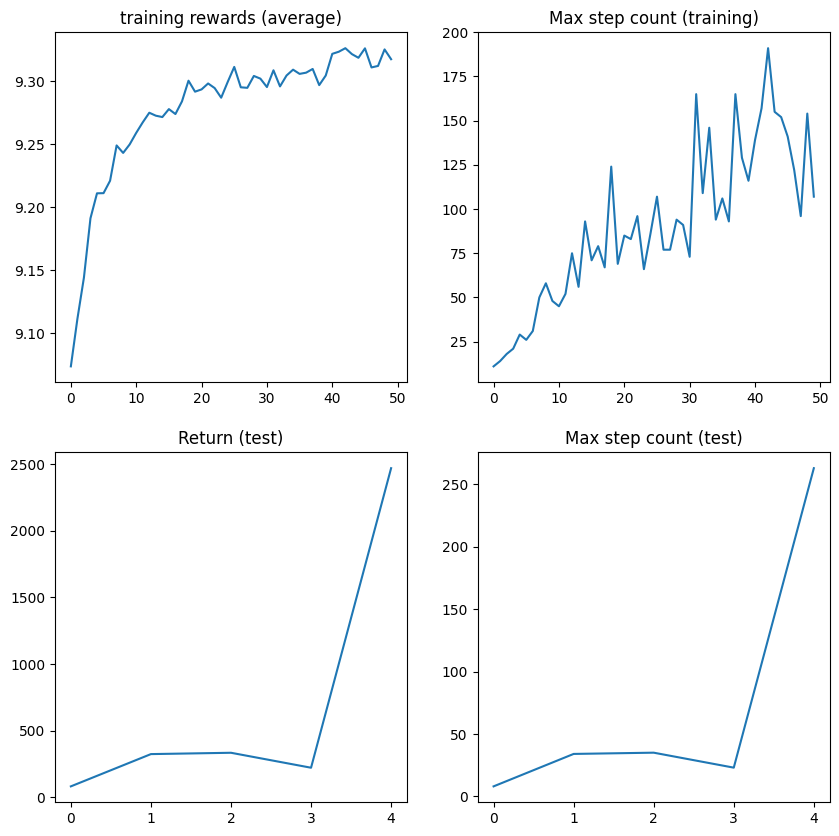

In [141]:
collector = SyncDataCollector(
    env,
    policy_module,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
    split_trajs=False,
    device=device,
)

replay_buffer = ReplayBuffer(
    storage=LazyTensorStorage(frames_per_batch),
    sampler=SamplerWithoutReplacement(),
)

advantage_module = GAE(
    gamma=gamma, lmbda=lmbda, value_network=value_module, average_gae=True
)

loss_module = ClipPPOLoss(
    actor=policy_module,
    critic=value_module,
    advantage_key="advantage",
    clip_epsilon=clip_epsilon,
    entropy_bonus=bool(entropy_eps),
    entropy_coef=entropy_eps,
    # these keys match by default but we set this for completeness
    value_target_key=advantage_module.value_target_key,
    critic_coef=1.0,
    gamma=0.99,
    loss_critic_type="smooth_l1",
)

optim = torch.optim.Adam(loss_module.parameters(), lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optim, total_frames // frames_per_batch, 0.0
)

logs = defaultdict(list)
pbar = tqdm(total=total_frames * frame_skip)
eval_str = ""

# We iterate over the collector until it reaches the total number of frames it was
# designed to collect:
for i, tensordict_data in enumerate(collector):
    # we now have a batch of data to work with. Let's learn something from it.
    for _ in range(num_epochs):
        # We'll need an "advantage" signal to make PPO work.
        # We re-compute it at each epoch as its value depends on the value
        # network which is updated in the inner loop.
        advantage_module(tensordict_data)
        data_view = tensordict_data.reshape(-1)
        replay_buffer.extend(data_view.cpu())
        for _ in range(frames_per_batch // sub_batch_size):
            subdata = replay_buffer.sample(sub_batch_size)
            loss_vals = loss_module(subdata.to(device))
            loss_value = (
                loss_vals["loss_objective"]
                + loss_vals["loss_critic"]
                + loss_vals["loss_entropy"]
            )

            # Optimization: backward, grad clipping and optimization step
            loss_value.backward()
            # this is not strictly mandatory but it's good practice to keep
            # your gradient norm bounded
            torch.nn.utils.clip_grad_norm_(loss_module.parameters(), max_grad_norm)
            optim.step()
            optim.zero_grad()

    logs["reward"].append(tensordict_data["next", "reward"].mean().item())
    pbar.update(tensordict_data.numel() * frame_skip)
    cum_reward_str = (
        f"average reward={logs['reward'][-1]: 4.4f} (init={logs['reward'][0]: 4.4f})"
    )
    logs["step_count"].append(tensordict_data["step_count"].max().item())
    stepcount_str = f"step count (max): {logs['step_count'][-1]}"
    logs["lr"].append(optim.param_groups[0]["lr"])
    lr_str = f"lr policy: {logs['lr'][-1]: 4.4f}"
    if i % 10 == 0:
        # We evaluate the policy once every 10 batches of data.
        # Evaluation is rather simple: execute the policy without exploration
        # (take the expected value of the action distribution) for a given
        # number of steps (1000, which is our ``env`` horizon).
        # The ``rollout`` method of the ``env`` can take a policy as argument:
        # it will then execute this policy at each step.
        with set_exploration_mode("mean"), torch.no_grad():
            # execute a rollout with the trained policy
            eval_rollout = env.rollout(1000, policy_module)
            logs["eval reward"].append(eval_rollout["next", "reward"].mean().item())
            logs["eval reward (sum)"].append(
                eval_rollout["next", "reward"].sum().item()
            )
            logs["eval step_count"].append(eval_rollout["step_count"].max().item())
            eval_str = (
                f"eval cumulative reward: {logs['eval reward (sum)'][-1]: 4.4f} "
                f"(init: {logs['eval reward (sum)'][0]: 4.4f}), "
                f"eval step-count: {logs['eval step_count'][-1]}"
            )
            del eval_rollout
    pbar.set_description(", ".join([eval_str, cum_reward_str, stepcount_str, lr_str]))

    # We're also using a learning rate scheduler. Like the gradient clipping,
    # this is a nice-to-have but nothing necessary for PPO to work.
    scheduler.step()

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(logs["reward"])
plt.title("training rewards (average)")
plt.subplot(2, 2, 2)
plt.plot(logs["step_count"])
plt.title("Max step count (training)")
plt.subplot(2, 2, 3)
plt.plot(logs["eval reward (sum)"])
plt.title("Return (test)")
plt.subplot(2, 2, 4)
plt.plot(logs["eval step_count"])
plt.title("Max step count (test)")
plt.show()

In [149]:
import torch
from torch import nn
from torchvision import transforms as T
from PIL import Image
import numpy as np
from pathlib import Path
from collections import deque
import random, datetime, os, copy

# Gym은 강화학습을 위한 OpenAI 툴킷입니다.
import gym
from gym.spaces import Box
from gym.wrappers import FrameStack

# OpenAI Gym을 위한 NES 에뮬레이터
from nes_py.wrappers import JoypadSpace

# OpenAI Gym에서의 슈퍼 마리오 환경 세팅
import gym_super_mario_bros

In [150]:
# 슈퍼 마리오 환경 초기화하기 (in v0.26 change render mode to 'human' to see results on the screen)
if gym.__version__ < '0.26':
    env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0", new_step_api=True)
else:
    env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0", render_mode='rgb', apply_api_compatibility=True)

# 상태 공간을 2가지로 제한하기
#   0. 오른쪽으로 걷기
#   1. 오른쪽으로 점프하기
env = JoypadSpace(env, [["right"], ["right", "A"]])

env.reset()
next_state, reward, done, trunc, info = env.step(action=0)
print(f"{next_state.shape},\n {reward},\n {done},\n {info}")

(240, 256, 3),
 0.0,
 False,
 {'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 400, 'world': 1, 'x_pos': 40, 'y_pos': 79}


In [151]:
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        """모든 `skip` 프레임만 반환합니다."""
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        """행동을 반복하고 포상을 더합니다."""
        total_reward = 0.0
        for i in range(self._skip):
            # 포상을 누적하고 동일한 작업을 반복합니다.
            obs, reward, done, trunk, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, trunk, info


class GrayScaleObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs_shape = self.observation_space.shape[:2]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def permute_orientation(self, observation):
        # [H, W, C] 배열을 [C, H, W] 텐서로 바꿉니다.
        observation = np.transpose(observation, (2, 0, 1))
        observation = torch.tensor(observation.copy(), dtype=torch.float)
        return observation

    def observation(self, observation):
        observation = self.permute_orientation(observation)
        transform = T.Grayscale()
        observation = transform(observation)
        return observation


class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        super().__init__(env)
        if isinstance(shape, int):
            self.shape = (shape, shape)
        else:
            self.shape = tuple(shape)

        obs_shape = self.shape + self.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        transforms = T.Compose(
            [T.Resize(self.shape), T.Normalize(0, 255)]
        )
        observation = transforms(observation).squeeze(0)
        return observation


# 래퍼를 환경에 적용합니다.
env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=84)
if gym.__version__ < '0.26':
    env = FrameStack(env, num_stack=4, new_step_api=True)
else:
    env = FrameStack(env, num_stack=4)

In [152]:
class Mario:
    def __init__():
        pass

    def act(self, state):
        """상태가 주어지면, 입실론-그리디 행동(epsilon-greedy action)을 선택해야 합니다."""
        pass

    def cache(self, experience):
        """메모리에 경험을 추가합니다."""
        pass

    def recall(self):
        """메모리로부터 경험을 샘플링합니다."""
        pass

    def learn(self):
        """일련의 경험들로 실시간 행동 가치(online action value) (Q) 함수를 업데이트 합니다."""
        pass

In [153]:
class Mario:
    def __init__(self, state_dim, action_dim, save_dir):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.save_dir = save_dir

        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        # 마리오의 DNN은 최적의 행동을 예측합니다 - 이는 학습하기 섹션에서 구현합니다.
        self.net = MarioNet(self.state_dim, self.action_dim).float()
        self.net = self.net.to(device=self.device)

        self.exploration_rate = 1
        self.exploration_rate_decay = 0.99999975
        self.exploration_rate_min = 0.1
        self.curr_step = 0

        self.save_every = 5e5  # Mario Net 저장 사이의 경험 횟수

    def act(self, state):
        """
    주어진 상태에서, 입실론-그리디 행동(epsilon-greedy action)을 선택하고, 스텝의 값을 업데이트 합니다.

    입력값:
    state (``LazyFrame``): 현재 상태에서의 단일 상태(observation)값을 말합니다. 차원은 (state_dim)입니다.
    출력값:
    ``action_idx`` (int): Mario가 수행할 행동을 나타내는 정수 값입니다.
    """
        # 임의의 행동을 선택하기
        if np.random.rand() < self.exploration_rate:
            action_idx = np.random.randint(self.action_dim)

        # 최적의 행동을 이용하기
        else:
            state = state[0].__array__() if isinstance(state, tuple) else state.__array__()
            state = torch.tensor(state, device=self.device).unsqueeze(0)
            action_values = self.net(state, model="online")
            action_idx = torch.argmax(action_values, axis=1).item()

        # exploration_rate 감소하기
        self.exploration_rate *= self.exploration_rate_decay
        self.exploration_rate = max(self.exploration_rate_min, self.exploration_rate)

        # 스텝 수 증가하기
        self.curr_step += 1
        return action_idx

In [154]:
class Mario(Mario):  # 연속성을 위한 하위 클래스입니다.
    def __init__(self, state_dim, action_dim, save_dir):
        super().__init__(state_dim, action_dim, save_dir)
        self.memory = deque(maxlen=100000)
        self.batch_size = 32

    def cache(self, state, next_state, action, reward, done):
        """
        Store the experience to self.memory (replay buffer)

        입력값:
        state (``LazyFrame``),
        next_state (``LazyFrame``),
        action (``int``),
        reward (``float``),
        done(``bool``))
        """
        def first_if_tuple(x):
            return x[0] if isinstance(x, tuple) else x
        state = first_if_tuple(state).__array__()
        next_state = first_if_tuple(next_state).__array__()

        state = torch.tensor(state, device=self.device)
        next_state = torch.tensor(next_state, device=self.device)
        action = torch.tensor([action], device=self.device)
        reward = torch.tensor([reward], device=self.device)
        done = torch.tensor([done], device=self.device)

        self.memory.append((state, next_state, action, reward, done,))

    def recall(self):
        """
        메모리에서 일련의 경험들을 검색합니다.
        """
        batch = random.sample(self.memory, self.batch_size)
        state, next_state, action, reward, done = map(torch.stack, zip(*batch))
        return state, next_state, action.squeeze(), reward.squeeze(), done.squeeze()

In [155]:
class MarioNet(nn.Module):
    """작은 CNN 구조
  입력 -> (conv2d + relu) x 3 -> flatten -> (dense + relu) x 2 -> 출력
  """

    def __init__(self, input_dim, output_dim):
        super().__init__()
        c, h, w = input_dim

        if h != 84:
            raise ValueError(f"Expecting input height: 84, got: {h}")
        if w != 84:
            raise ValueError(f"Expecting input width: 84, got: {w}")

        self.online = nn.Sequential(
            nn.Conv2d(in_channels=c, out_channels=32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
        )

        self.target = copy.deepcopy(self.online)

        # Q_target 매개변수 값은 고정시킵니다.
        for p in self.target.parameters():
            p.requires_grad = False

    def forward(self, input, model):
        if model == "online":
            return self.online(input)
        elif model == "target":
            return self.target(input)

class Mario(Mario):
    def __init__(self, state_dim, action_dim, save_dir):
        super().__init__(state_dim, action_dim, save_dir)
        self.gamma = 0.9

    def td_estimate(self, state, action):
        current_Q = self.net(state, model="online")[
            np.arange(0, self.batch_size), action
        ]  # Q_online(s,a)
        return current_Q

    @torch.no_grad()
    def td_target(self, reward, next_state, done):
        next_state_Q = self.net(next_state, model="online")
        best_action = torch.argmax(next_state_Q, axis=1)
        next_Q = self.net(next_state, model="target")[
            np.arange(0, self.batch_size), best_action
        ]
        return (reward + (1 - done.float()) * self.gamma * next_Q).float()

class Mario(Mario):
    def __init__(self, state_dim, action_dim, save_dir):
        super().__init__(state_dim, action_dim, save_dir)
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=0.00025)
        self.loss_fn = torch.nn.SmoothL1Loss()

    def update_Q_online(self, td_estimate, td_target):
        loss = self.loss_fn(td_estimate, td_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def sync_Q_target(self):
        self.net.target.load_state_dict(self.net.online.state_dict())

class Mario(Mario):
    def save(self):
        save_path = (
            self.save_dir / f"mario_net_{int(self.curr_step // self.save_every)}.chkpt"
        )
        torch.save(
            dict(model=self.net.state_dict(), exploration_rate=self.exploration_rate),
            save_path,
        )
        print(f"MarioNet saved to {save_path} at step {self.curr_step}")

In [156]:
class Mario(Mario):
    def __init__(self, state_dim, action_dim, save_dir):
        super().__init__(state_dim, action_dim, save_dir)
        self.burnin = 1e4  # 학습을 진행하기 전 최소한의 경험값.
        self.learn_every = 3  # Q_online 업데이트 사이의 경험 횟수.
        self.sync_every = 1e4  # Q_target과 Q_online sync 사이의 경험 수

    def learn(self):
        if self.curr_step % self.sync_every == 0:
            self.sync_Q_target()

        if self.curr_step % self.save_every == 0:
            self.save()

        if self.curr_step < self.burnin:
            return None, None

        if self.curr_step % self.learn_every != 0:
            return None, None

        # 메모리로부터 샘플링을 합니다.
        state, next_state, action, reward, done = self.recall()

        # TD 추정값을 가져옵니다.
        td_est = self.td_estimate(state, action)

        # TD 목표값을 가져옵니다.
        td_tgt = self.td_target(reward, next_state, done)

        # 실시간 Q(Q_online)을 통해 역전파 손실을 계산합니다.
        loss = self.update_Q_online(td_est, td_tgt)

        return (td_est.mean().item(), loss)

In [157]:
import numpy as np
import time, datetime
import matplotlib.pyplot as plt


class MetricLogger:
    def __init__(self, save_dir):
        self.save_log = save_dir / "log"
        with open(self.save_log, "w") as f:
            f.write(
                f"{'Episode':>8}{'Step':>8}{'Epsilon':>10}{'MeanReward':>15}"
                f"{'MeanLength':>15}{'MeanLoss':>15}{'MeanQValue':>15}"
                f"{'TimeDelta':>15}{'Time':>20}\n"
            )
        self.ep_rewards_plot = save_dir / "reward_plot.jpg"
        self.ep_lengths_plot = save_dir / "length_plot.jpg"
        self.ep_avg_losses_plot = save_dir / "loss_plot.jpg"
        self.ep_avg_qs_plot = save_dir / "q_plot.jpg"

        # 지표(Metric)와 관련된 리스트입니다.
        self.ep_rewards = []
        self.ep_lengths = []
        self.ep_avg_losses = []
        self.ep_avg_qs = []

        # 모든 record() 함수를 호출한 후 이동 평균(Moving average)을 계산합니다.
        self.moving_avg_ep_rewards = []
        self.moving_avg_ep_lengths = []
        self.moving_avg_ep_avg_losses = []
        self.moving_avg_ep_avg_qs = []

        # 현재 에피스드에 대한 지표를 기록합니다.
        self.init_episode()

        # 시간에 대한 기록입니다.
        self.record_time = time.time()

    def log_step(self, reward, loss, q):
        self.curr_ep_reward += reward
        self.curr_ep_length += 1
        if loss:
            self.curr_ep_loss += loss
            self.curr_ep_q += q
            self.curr_ep_loss_length += 1

    def log_episode(self):
        "에피스드의 끝을 표시합니다."
        self.ep_rewards.append(self.curr_ep_reward)
        self.ep_lengths.append(self.curr_ep_length)
        if self.curr_ep_loss_length == 0:
            ep_avg_loss = 0
            ep_avg_q = 0
        else:
            ep_avg_loss = np.round(self.curr_ep_loss / self.curr_ep_loss_length, 5)
            ep_avg_q = np.round(self.curr_ep_q / self.curr_ep_loss_length, 5)
        self.ep_avg_losses.append(ep_avg_loss)
        self.ep_avg_qs.append(ep_avg_q)

        self.init_episode()

    def init_episode(self):
        self.curr_ep_reward = 0.0
        self.curr_ep_length = 0
        self.curr_ep_loss = 0.0
        self.curr_ep_q = 0.0
        self.curr_ep_loss_length = 0

    def record(self, episode, epsilon, step):
        mean_ep_reward = np.round(np.mean(self.ep_rewards[-100:]), 3)
        mean_ep_length = np.round(np.mean(self.ep_lengths[-100:]), 3)
        mean_ep_loss = np.round(np.mean(self.ep_avg_losses[-100:]), 3)
        mean_ep_q = np.round(np.mean(self.ep_avg_qs[-100:]), 3)
        self.moving_avg_ep_rewards.append(mean_ep_reward)
        self.moving_avg_ep_lengths.append(mean_ep_length)
        self.moving_avg_ep_avg_losses.append(mean_ep_loss)
        self.moving_avg_ep_avg_qs.append(mean_ep_q)

        last_record_time = self.record_time
        self.record_time = time.time()
        time_since_last_record = np.round(self.record_time - last_record_time, 3)

        print(
            f"Episode {episode} - "
            f"Step {step} - "
            f"Epsilon {epsilon} - "
            f"Mean Reward {mean_ep_reward} - "
            f"Mean Length {mean_ep_length} - "
            f"Mean Loss {mean_ep_loss} - "
            f"Mean Q Value {mean_ep_q} - "
            f"Time Delta {time_since_last_record} - "
            f"Time {datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}"
        )

        with open(self.save_log, "a") as f:
            f.write(
                f"{episode:8d}{step:8d}{epsilon:10.3f}"
                f"{mean_ep_reward:15.3f}{mean_ep_length:15.3f}{mean_ep_loss:15.3f}{mean_ep_q:15.3f}"
                f"{time_since_last_record:15.3f}"
                f"{datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S'):>20}\n"
            )

        for metric in ["ep_rewards", "ep_lengths", "ep_avg_losses", "ep_avg_qs"]:
            plt.plot(getattr(self, f"moving_avg_{metric}"))
            plt.savefig(getattr(self, f"{metric}_plot"))
            plt.clf()

In [158]:
use_cuda = torch.cuda.is_available()
print(f"Using CUDA: {use_cuda}")
print()

save_dir = Path("checkpoints") / datetime.datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
save_dir.mkdir(parents=True)

mario = Mario(state_dim=(4, 84, 84), action_dim=env.action_space.n, save_dir=save_dir)

logger = MetricLogger(save_dir)

episodes = 10
for e in range(episodes):

    state = env.reset()

    # 게임을 실행시켜봅시다!
    while True:

        # 현재 상태에서 에이전트 실행하기
        action = mario.act(state)

        # 에이전트가 액션 수행하기
        next_state, reward, done, trunc, info = env.step(action)

        # 기억하기
        mario.cache(state, next_state, action, reward, done)

        # 배우기
        q, loss = mario.learn()

        # 기록하기
        logger.log_step(reward, loss, q)

        # 상태 업데이트하기
        state = next_state

        # 게임이 끝났는지 확인하기
        if done or info["flag_get"]:
            break

    logger.log_episode()

    if e % 20 == 0:
        logger.record(episode=e, epsilon=mario.exploration_rate, step=mario.curr_step)

Using CUDA: True



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Episode 0 - Step 156 - Epsilon 0.9999610007556099 - Mean Reward 724.0 - Mean Length 156.0 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 0.975 - Time 2024-01-31T00:37:07


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
